In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')

In [2]:
# Manually curated collection of fast growers
fast_growers_df = pd.read_csv('../data/physiology/fastest_growers.csv')

# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

In [3]:
mask = np.logical_and(kayser_chemostat_df.D_per_h.notnull(),
                      kayser_chemostat_df.r_glucose_mmol_g_h.notnull())
masked_kayser = kayser_chemostat_df[mask]
kayser_regression = linregress(masked_kayser.D_per_h, masked_kayser.r_glucose_mmol_g_h)
kayser_regression

LinregressResult(slope=9.330509186719699, intercept=0.16059826890195206, rvalue=0.9960383317181503, pvalue=6.487887131442609e-13, stderr=0.2511634516689206, intercept_stderr=0.0669850545879041)

/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

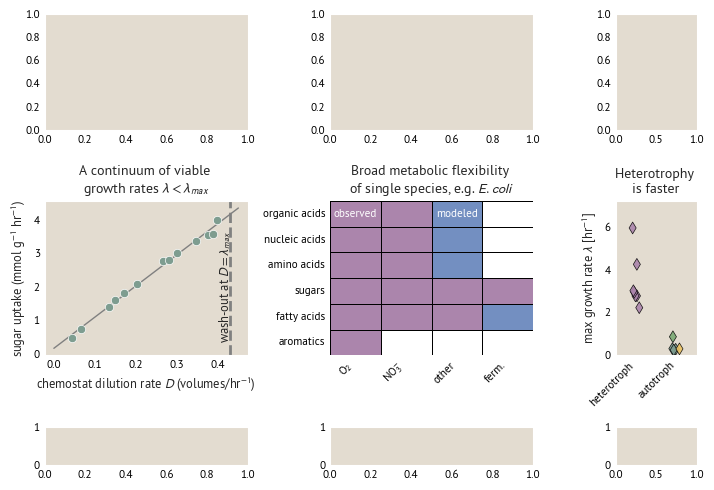

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 5), 
                        gridspec_kw={'width_ratios': [1, 1, 0.4], 'height_ratios':[0.75, 1, 0.25]})

# TODO: clear first row. 

# Panel on maximum growth rate -- E. coli glucose uptake rates in a chemostate from Kayser et al. 
plt.sca(axs[1,0])
sns.scatterplot(data=kayser_chemostat_df, x='D_per_h', y='r_glucose_mmol_g_h', color=colors['dark_green'])

# Plot a regression
Ds = np.arange(0, masked_kayser.D_per_h.max()+0.1, 0.05)
pred_uptake = kayser_regression.slope*Ds + kayser_regression.intercept
plt.plot(Ds, pred_uptake, ls='-', lw=1, color='grey', zorder=-1)

plt.ylabel('sugar uptake (mmol g$^{-1}$ hr$^{-1}$)')
plt.xlabel('chemostat dilution rate $D$ (volumes/hr$^{-1}$)')

plt.axvline(0.43, color='grey', ls='--')
plt.text(0.417, 2, 'wash-out at $D = \lambda_{max}$', va='center', ha='center', rotation=90, fontsize=9)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')

# Panel on range of metabolic modes. 
plt.sca(axs[1,1])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('Broad metabolic flexibility \nof single species, e.g. $E. coli$')
plt.text(0.5, 0.5, 'observed', ha='center', va='center', fontsize=8, color='w')
plt.text(2.5, 0.5, 'modeled', ha='center', va='center', fontsize=8, color='w')

plt.sca(axs[1,2])
cnames = 'dark_green,purple,yellow,green'.split(',')
pal = [colors[c] for c in cnames]
sns.stripplot(data=fast_growers_df, y='growth_rate_hr',
              x='group', hue='category', marker='d', size=6,
              jitter=0.1, palette=pal, order='heterotroph,autotroph'.split(','),
              alpha=0.9, edgecolor='k', linewidth=0.5)
plt.xlabel('')
plt.legend().set_visible(False)
plt.ylabel('max growth rate $\lambda$ [hr$^{-1}$]')
plt.xticks(ha='right', rotation=45)
plt.ylim(0, 7.2)
plt.title('Heterotrophy \nis faster')

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()